In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import numpy as np
from h5py import File
import napari

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"/figures/output")

rc = {
    # "figure.facecolor": "#FFFFFF00",
    # "axes.facecolor": "#FFFFFF00",
    "legend.framealpha": 0.2,
    "lines.color": "k",
    "svg.fonttype": "none",
}

sns.set_context("paper")
sns.set_theme(style="ticks", font="Arial", rc=rc)

# print(mpl.font_manager.get_font_names())
nc_pal = {11: "coral", 12: "mediumseagreen", 13: "cadetblue", 14: "#895794"}
trk_pal = ["green", "red"]
four_color_pal = ["#44af69", "#f8333c", "#fcab10", "#2b9eb3"]

In [2]:
spots_dfs = []
metadatas = []

directories = list(spots_directory.glob("*_spots.h5"))
print([f"{d.stem}" for d in directories])

for i, spots_path in tqdm(enumerate(spots_directory.glob("*_spots.h5")), desc="reading spots dfs"):
    spots_df = pd.read_hdf(spots_path, key="df")

    spots_df["source"] = i

    metadata = {}

    with File(spots_path, "r") as f:
        m = f["metadata"]
        metadata.update(m.attrs)

    metadatas.append(metadata)

    # print(metadata)

    dtw_path = spots_directory / "dtw" / f"{spots_path.stem}_dtw.h5"
    if dtw_path.exists():
        dtw_update = pd.read_hdf(dtw_path, key="df")
        spots_df = pd.merge(
            spots_df, dtw_update, left_index=True, right_index=True, how="left"
        )
        spots_df["cycle_pseudotime"] = spots_df["pseudotime"] + spots_df["cycle"] - 11
    else:
        spots_df["distance"] = np.nan  # rename this later
        spots_df["pseudotime"] = np.nan

    spots_dfs.append(spots_df)

all_dfs = pd.concat(spots_dfs, ignore_index=True)

['lightsheet_20241104_spots', 'lightsheet_20250131_spots', 'lightsheet_20250206_spots', 'lightsheet_20250414_spots', 'lightsheet_20250625_spots', 'lightsheet_20250627_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots', 'lightsheet_trk_20250325_spots']


reading spots dfs: 14it [00:13,  1.07it/s]


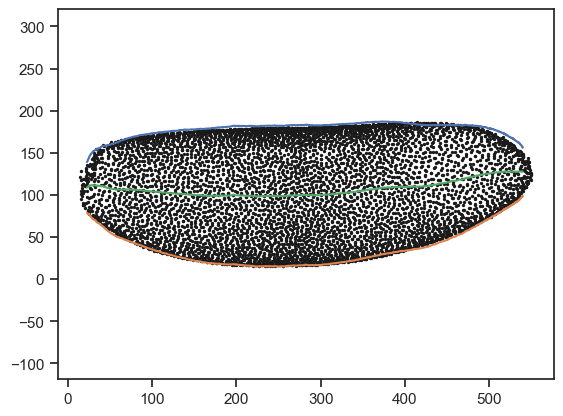

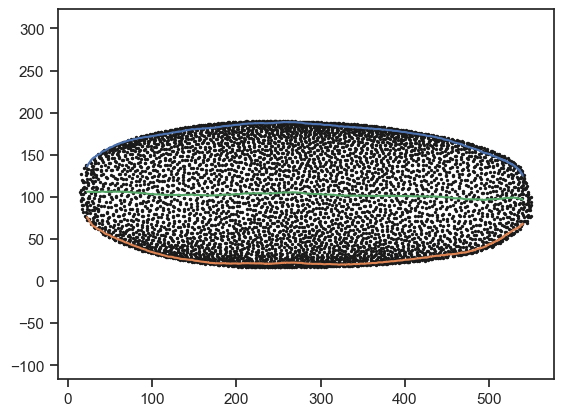

(5000,)


In [14]:
df = spots_dfs[5].copy()

frame = df["frame"].max()
subset = df[df["frame"] == frame]

def to_parametric(coeffs, thetas):
    cs = np.cos(thetas)
    sn = np.sin(thetas)

    l1 = coeffs[0] * cs**2 + coeffs[1] * cs * sn + coeffs[2] * sn**2
    l2 = coeffs[3] * cs + coeffs[4] * sn

    rvals = (-l1 + np.sqrt(l2**2 + 4*l1)) / (2*l1 + 1e-10)

    return rvals

xv = []
zv = []
yv = []
r_vals = []
z_outline = []
x_outline = []
z_means = []
x_means = []

n = 5000
goldenRatio = (1 + 5**0.5)/2
i = np.arange(0, n)
thetas = 2 *np.pi * i / goldenRatio
phi = np.arccos(1 - 2*(i+0.5)/n)
ap_pos = np.cos(phi) / 2 + 0.5

for point, theta in zip(ap_pos, thetas):
    data = subset[subset["AP"].between(point - 0.025, point + 0.025)]

    X = np.expand_dims(data["x"].values, -1)
    Y = np.expand_dims(data["z"].values, -1)

    xmean = X.mean()
    ymean = Y.mean()

    X = X - X.mean()
    Y = Y - Y.mean()

    A = np.hstack([X**2, X * Y, Y**2, X, Y])
    b = np.ones_like(X)
    x = np.linalg.lstsq(A, b)[0].squeeze()

    # thetas = np.linspace(0, 2 * np.pi, 100)
    rvals = to_parametric(x, theta)

    xv.append(rvals * np.cos(theta) + xmean)
    zv.append(rvals * np.sin(theta) + ymean)
    yv.append(np.mean(data["y"]))

    r_vals.append(rvals)
    x_outline.append(xmean + rvals)
    z_outline.append(ymean + rvals)
    z_means.append(ymean)
    x_means.append(xmean)

    x = rvals * np.cos(thetas)
    z = rvals * np.sin(thetas)
    # plt.plot(x + xmean, z + ymean, color="black", linewidth=1.5, label=f"AP {point:.2f}")
    #
    # print(x)
    #
    # sns.scatterplot(data, x="x", y="z", hue="y")
    # plt.show()

z_means = np.array(z_means)
x_means = np.array(x_means)
r_vals = np.array(r_vals)

plt.plot(yv, pd.Series(r_vals + z_means).rolling(50, center=True).mean())
plt.plot(yv, pd.Series(z_means - r_vals).rolling(50, center=True).mean())
plt.plot(yv, pd.Series(z_means).rolling(50, center=True).mean())
plt.scatter(subset["y"], subset["z"], color="k", s=2)
plt.gca().axis("equal")
plt.show()


plt.plot(yv, pd.Series(x_means + r_vals).rolling(50, center=True).mean())
plt.plot(yv, pd.Series(x_means - r_vals).rolling(50, center=True).mean())
plt.plot(yv, pd.Series(x_means).rolling(50, center=True).mean())
plt.scatter(subset["y"], subset["x"], color="k", s=2)
plt.gca().axis("equal")

plt.show()

print(np.array(zv).shape)

# viewer = napari.Viewer(ndisplay=3)
# X = np.array([xv, yv, zv]).T
# points1 = viewer.add_points(
#     X, face_color="blue", size=10, name="apical points"
# )
# X2 = subset[["x", "y", "z"]].values
# points2 = viewer.add_points(
#     X2, face_color="red", size=5, name="nuclei"
# )
#
# napari.run()
#
# from scipy.spatial.distance import cdist
#
# anterior_densities = []
# posterior_densities = []
# center_densities = []
# anterior_starts = []
# posterior_starts = []
# center_starts = []
# ap_density_starts = []
# ap_density = []
# trks = []
#
#
#
# for df in spots_dfs:
#
#     fig, ax = plt.subplots(figsize=(6, 4))
#
#     df = df.copy()
#     end_frame = df["frame"].max()
#     trk = df["trk"].iloc[0]
#
#     subset = df[df["frame"] == end_frame]
#
#     def to_parametric(coeffs, thetas):
#         cs = np.cos(thetas)
#         sn = np.sin(thetas)
#
#         l1 = coeffs[0] * cs**2 + coeffs[1] * cs * sn + coeffs[2] * sn**2
#         l2 = coeffs[3] * cs + coeffs[4] * sn
#
#         rvals = (-l1 + np.sqrt(l2**2 + 4*l1)) / (2*l1 + 1e-10)
#
#         return rvals
#
#     xv = []
#     zv = []
#     yv = []
#
#     n = 1000
#     goldenRatio = (1 + 5**0.5)/2
#     i = np.arange(0, n)
#     thetas = 2 *np.pi * i / goldenRatio
#     phi = np.arccos(1 - 2*(i+0.5)/n)
#     ap_pos = np.cos(phi) / 2 + 0.5
#
#     for point, theta in zip(ap_pos, thetas):
#         data = subset[subset["AP"].between(point - 0.025, point + 0.025)]
#
#         X = np.expand_dims(data["x"].values, -1)
#         Y = np.expand_dims(data["z"].values, -1)
#
#         xmean = X.mean()
#         ymean = Y.mean()
#
#         X = X - X.mean()
#         Y = Y - Y.mean()
#
#         A = np.hstack([X**2, X * Y, Y**2, X, Y])
#         b = np.ones_like(X)
#         x = np.linalg.lstsq(A, b)[0].squeeze()
#
#         # thetas = np.linspace(0, 2 * np.pi, 100)
#         rvals = to_parametric(x, theta)
#
#         xv.append(rvals * np.cos(theta) + xmean)
#         zv.append(rvals * np.sin(theta) + ymean)
#         yv.append(np.mean(data["y"]))
#
#     start_frame = int(np.max(df["frame"].values[df["time_since_nc11"] < -3]))
#
#     for frame, name in zip([start_frame, end_frame], ["NC 10", "NC 14"]):
#
#         frame_subset = df[df["frame"] == frame]
#         dis = cdist(
#             np.array([xv, yv, zv]).T,
#             frame_subset[["x", "y", "z"]].values
#         )
#
#         # dis = cdist(
#         #     np.array([xv, yv, zv]).T,
#         #     np.array([xv, yv, zv]).T
#         # )
#
#         print(dis.shape)
#
#         densities = np.sum(dis < 30, axis=1) / dis.shape[1]
#
#         ap_cut = (ap_pos // 0.05) * 0.05
#         ap_d = pd.Series(densities).groupby(ap_cut).mean()
#         center_val = np.mean([ap_d.loc[0.45], ap_d.loc[0.50]])
#
#
#         # sns.lineplot(x=ap_cut, y=densities / center_val, label=name, linewidth=2.0, ax=ax)
#
#         if frame == end_frame:
#             ap_density.append(ap_d)
#             trks.append(trk)
#
#             anterior_densities.append(ap_d.loc[0.05])
#             posterior_densities.append(ap_d.loc[0.90])
#             center_densities.append(np.mean([ap_d.loc[0.45], ap_d.loc[0.50]]))
#
#         else:
#             ap_density_starts.append(ap_d)
#             anterior_starts.append(ap_d.loc[0.05])
#             posterior_starts.append(ap_d.loc[0.90])
#             center_starts.append(np.mean([ap_d.loc[0.45], ap_d.loc[0.50]]))


    # sns.kdeplot(densities, label=f"frame {frame}")
    # plt.xlabel("AP axis position")
    # plt.ylabel("Relative density")
    #
    # plt.show()

    # sns.scatterplot(x=ap_pos, y=thetas % (2*np.pi), hue=densities, palette="mako", s=50, label=frame)
# plt.show()

# sns.kdeplot(densities)


# napari.run()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:4.428e-01 t=7.936e-01


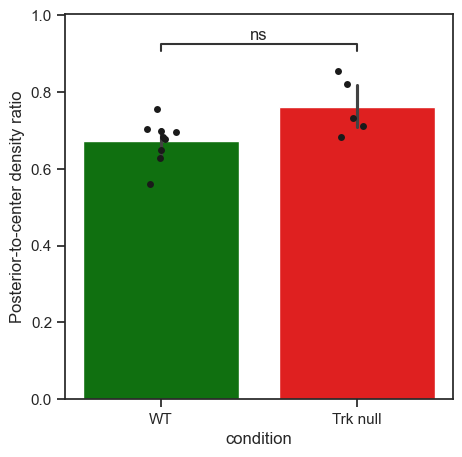

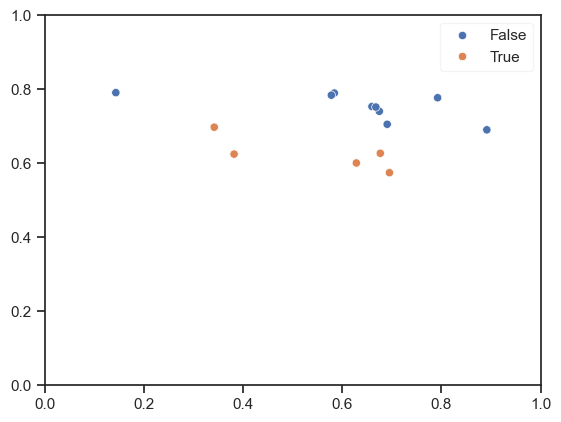

In [4]:
a_ratio_starts = [a/c for a, c in zip(anterior_starts, center_starts)]
p_ratio_starts = [p/c for p, c in zip(posterior_starts, center_starts)]

a_ratio = [a/c for a, c in zip(anterior_densities, center_densities)]
p_ratio = [p/c for p, c in zip(posterior_densities, center_densities)]

fig, ax = plt.subplots(figsize=(5, 5))

sns.barplot(x=["Trk null" if t else "WT" for t in trks], y=p_ratio_starts, hue=trks, palette=trk_pal, legend=False)
sns.stripplot(x=["Trk null" if t else "WT" for t in trks], y=p_ratio_starts, color="k", legend=False)

from statannotations.Annotator import Annotator


pairs = [(True, False)]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='boxplot',
           x=trks, y=a_ratio_starts, legend=False)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()

plt.ylabel("Posterior-to-center density ratio")
plt.xlabel("condition")
plt.show()

# plt.show()

fig, ax = plt.subplots()
sns.scatterplot(x=a_ratio_starts, y=a_ratio, hue=trks)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.show()

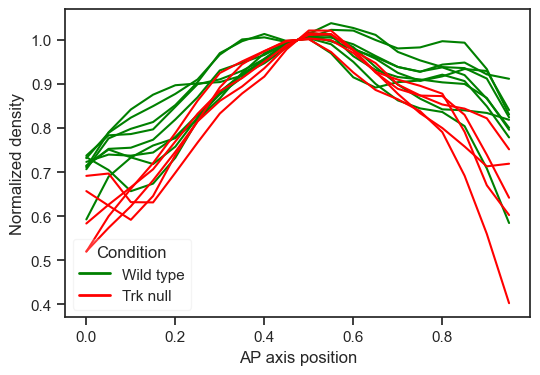

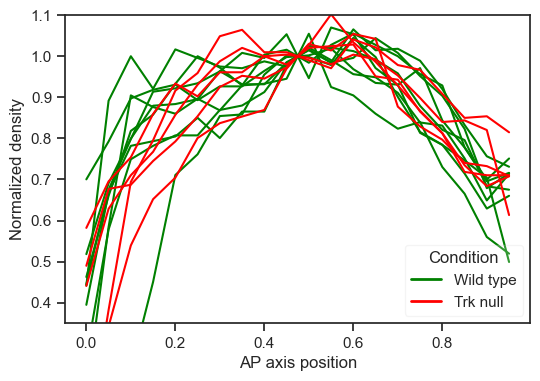

AttributeError: 'Rectangle' object has no attribute 'alpha'

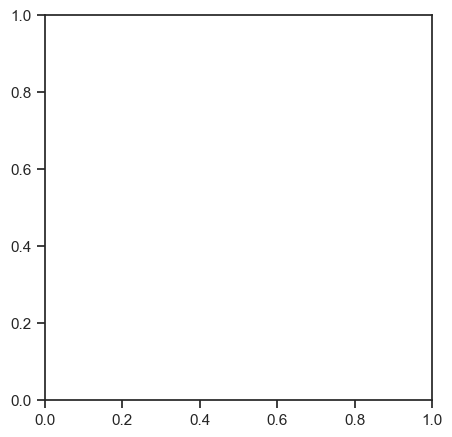

In [5]:
from statannotations.Annotator import Annotator
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(6, 4))
for pp, cd, trk in zip(ap_density, center_densities, trks):
    vals = pp.values / cd
    sns.lineplot(x=pp.index, y=vals, color=trk_pal[int(trk)], alpha=1.0, ax=ax, legend=False)

a_ratio = [a/c for a, c in zip(anterior_densities, center_densities)]
p_ratio = [p/c for p, c in zip(posterior_densities, center_densities)]

custom_lines = [Line2D([0], [0], color=trk_pal[i], lw=2) for i in range(2)]

ax.legend(custom_lines, ["Wild type", "Trk null"], title="Condition", loc="lower left")

plt.xlabel("AP axis position")
plt.ylabel("Normalized density")

plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
for pp, cd, trk in zip(ap_density_starts, center_starts, trks):
    vals = pp.values / cd
    sns.lineplot(x=pp.index, y=vals, color=trk_pal[int(trk)], alpha=1.0, ax=ax, legend=False)

a_ratio = [a/c for a, c in zip(anterior_densities, center_densities)]
p_ratio = [p/c for p, c in zip(posterior_densities, center_densities)]

custom_lines = [Line2D([0], [0], color=trk_pal[i], lw=2) for i in range(2)]

ax.legend(custom_lines, ["Wild type", "Trk null"], title="Condition", loc="lower right")

plt.xlabel("AP axis position")
plt.ylabel("Normalized density")

plt.ylim([0.35, 1.1])

plt.show()

fig, ax = plt.subplots(figsize=(5, 5))

fig.patch.alpha(0.0)

sns.barplot(x=["trk" if t else "wt" for t in trks], y=a_ratio, hue=trks, palette=trk_pal)
sns.stripplot(x=["trk" if t else "wt" for t in trks], y=a_ratio, color="k", legend=False)

pairs = [(True, False)]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='boxplot',
           x=trks, y=a_ratio)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()
plt.ylabel("Anterior-to-center density ratio")
plt.xlabel("condition")

plt.show()

fig, ax = plt.subplots(figsize=(5, 5))

sns.barplot(x=["trk" if t else "wt" for t in trks], y=p_ratio, hue=trks, palette=trk_pal)
sns.stripplot(x=["trk" if t else "wt" for t in trks], y=p_ratio, color="k", legend=False)

pairs = [(True, False)]

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='boxplot',
           x=trks, y=p_ratio)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()
plt.ylabel("Posterior-to-center density ratio")
plt.xlabel("condition")

plt.show()

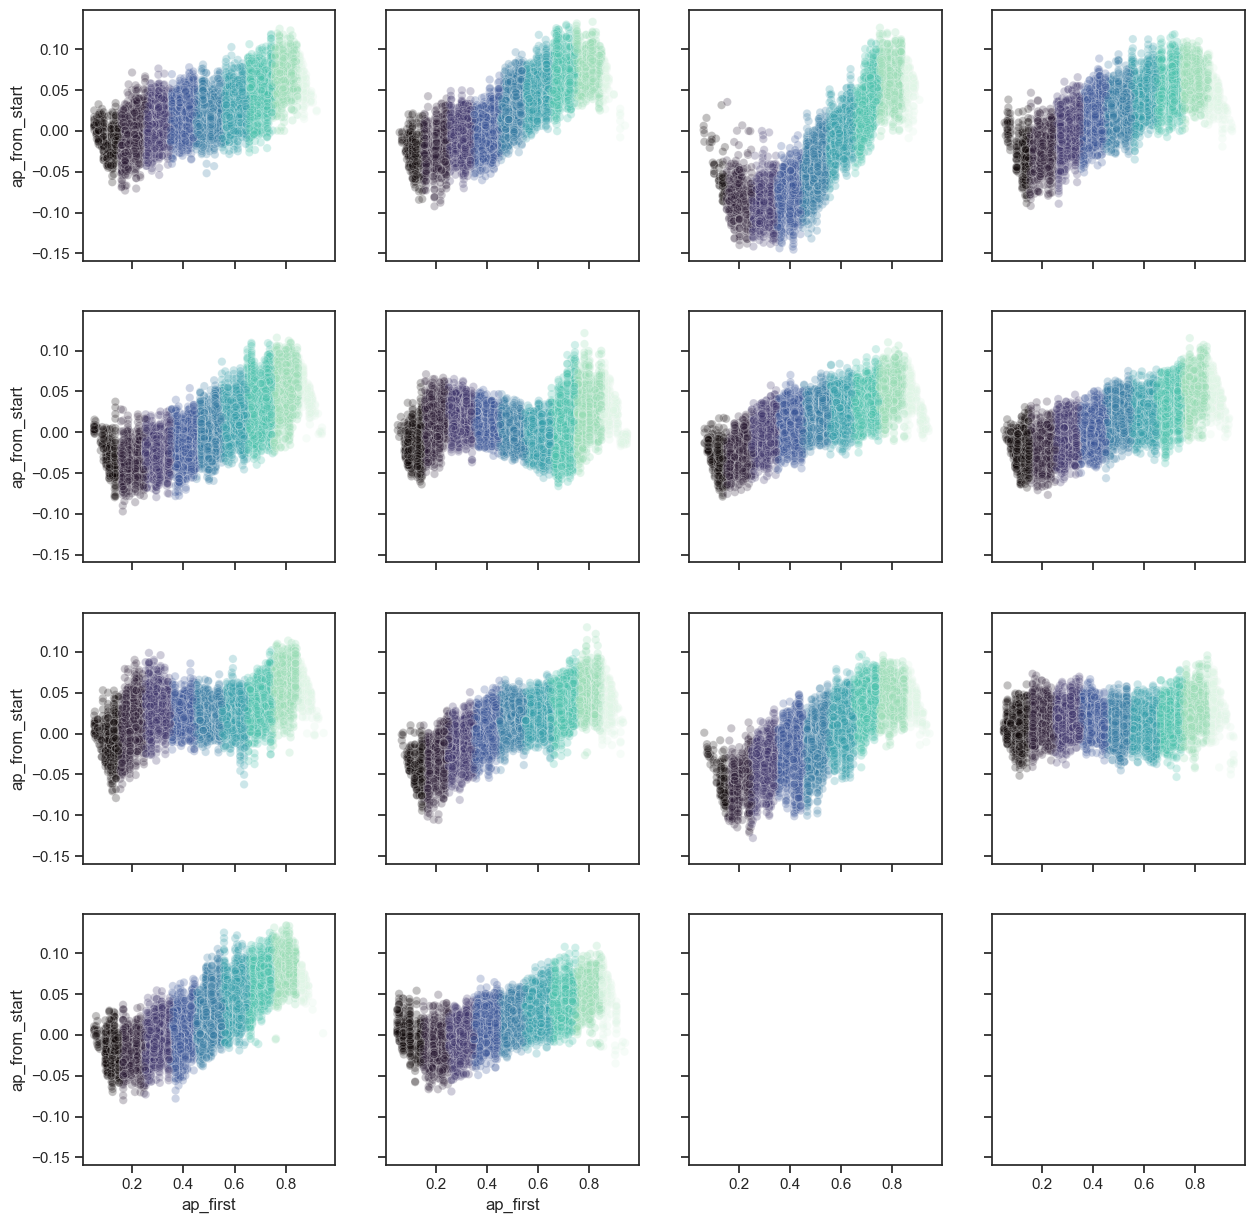

count    14.000000
mean      0.119354
std       0.052603
min       0.043033
25%       0.087956
50%       0.104956
75%       0.153583
max       0.231553
dtype: float64
LinregressResult(slope=np.float64(2.3769315830955646), intercept=np.float64(0.053989286076789655), rvalue=np.float64(0.8832944321477035), pvalue=np.float64(2.8240643250994202e-05), stderr=np.float64(0.36418785995272424), intercept_stderr=np.float64(0.04722486467454804))


4.5e-05

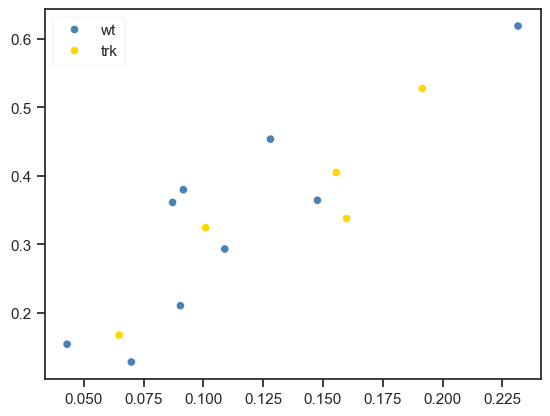

In [9]:
from scipy.stats import linregress

fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)

slopes = []
x_intercepts = []
trk = []

for df, ax in zip(spots_dfs, axes.flatten()):
    df = df.copy()

    df = df[df["AP"].between(0.05, 0.95)]

    df["ap_first"] = df["track_id"].map(df.groupby("track_id")["AP"].first())

    df["ap_bin"] = np.round(((df["ap_first"] - 0.05) // 0.10) * 0.10 + 0.05, 2)

    df["ap_from_start"] = df["AP"] - df["track_id"].map(
        df.groupby("track_id")["AP"].first()
    )
    #
    # df["theta_from_start"] = df["theta"] - df["track_id"].map(
    #     df.groupby("track_id")["theta"].first()
    # )
    #
    # df["theta_from_start"] = np.abs(df["theta_from_start"])
    # df["theta_from_start"] = df["theta_from_start"].where(
    #     df["theta_from_start"] < np.pi, 2 * np.pi - df["theta_from_start"]
    # )

    regression = linregress(
        df["ap_first"], df["ap_from_start"]
    )

    slopes.append(regression.slope)
    x_intercepts.append(-regression.intercept / regression.slope)

    trk.append("trk" if df["trk"][0] else "wt")

    # print(regression)

    # sns.violinplot(df[df["frame"] == df["frame"].max()], x="ap_bin", y="ap_from_start", hue="ap_bin", split=True, palette="mako", ax=ax, legend=False)
    sns.scatterplot(df[df["frame"] == df["frame"].max()], x="ap_first", y="ap_from_start", hue="ap_bin", palette="mako", ax=ax, legend=False, alpha=0.25)
    # sns.lineplot(df[df["frame"] == df["frame"].max()], x="ap_bin", y="ap_from_start", color="k", ax=ax, legend=False, errorbar=None)
plt.show()

sns.scatterplot(x=slopes, y=x_intercepts, hue=trk, palette=trk_pal)

regression = linregress(slopes, x_intercepts)

print(pd.Series(slopes).describe())

print(regression)

0.000045


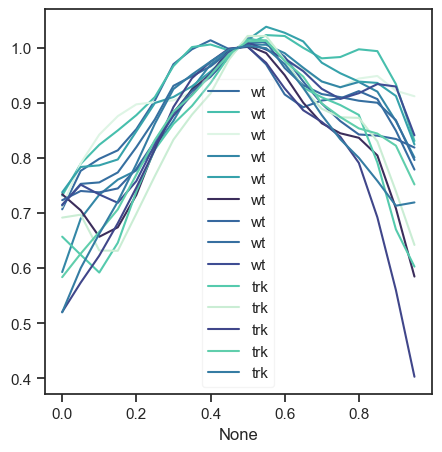

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
for pp, cd, slope, trk in zip(ap_density, center_densities, slopes, trks):
    vals = pp.values / cd
    sns.lineplot(x=pp.index, y=vals, label="trk" if trk else "wt", color=sns.color_palette("mako", as_cmap=True)(slope*5), alpha=1.0, ax=ax)